In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from scipy.special import binom 

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import transforms
from torch.autograd import Variable
import torch.utils.data as data_utils
import torch.nn.init as init

from collections import Counter
import operator
import copy 
from itertools import product,combinations
from time import time 
#from IPython.core.display import display

%matplotlib inline

## code extracted from https://www.kaggle.com/code/graymant/breast-cancer-diagnosis-with-pytorch
## SV code extracted from https://github.com/mburaksayici/ExplainableAI-Pure-Numpy/blob/main/KernelSHAP-Pure-Numpy.ipynb

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#from utils import read_data,label_mapping_FEMNIST
from utils import *
from models import Net, Federated_Averaging, Global_Model,Local_Model,AFPL,training_loop
from data import FEMNIST_dataset, Partition_MNIST_NIID,MNIST_NIID_dataset
import keras

import yaml 
stream = 'settings\train_settings.yaml'
with open('settings/train_settings.yaml','r') as file:
    settings = yaml.safe_load(file)
    
print(settings)
### Divide MNIST dataset over a total of 10 clients. Each client gets 2 classes.
train_data, test_data = keras.datasets.mnist.load_data()
instance = Partition_MNIST_NIID(train_data[0],train_data[1])
classes_per_user = 3
total_clients = 12
train_partition = instance.create_partition(4,classes_per_user,total_clients)
test_instance = Partition_MNIST_NIID(test_data[0], test_data[1])
test_partition = test_instance.create_partition_test(instance.sample_array)

2023-03-17 14:38:17.081422: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


{'experiment_name': 'test_adaptive_a4', 'Date': '22_11_2022', 'Dataset': 'MNIST_niid', 'n_clients': 10, 'total_clients': 10, 'classes_per_user': 10, 'network': 'Net', 'n_epochs': 100, 'local_iterations': 1, 'type': 'afpl', 'log_interval': 25}
[[1 2 0]
 [2 0 1]
 [3 1 2]
 [1 0 3]
 [0 1 2]
 [0 2 1]
 [2 3 0]
 [0 1 3]
 [0 3 2]
 [3 2 0]
 [3 2 0]
 [1 3 2]]


In [3]:
# SHAP kernel 

class SHAP_kernel(object): 
    def __init__(self,n_clients,samples,verbose=True):
        self.samples = samples 
        self.n_clients = n_clients 
        self.verbose = verbose 
        self.indices = []
        
    def first_guess(self): 
        self.shap_weights = [(self.n_clients-1)/(z*(self.n_clients-z)) for z in list(range(1,self.n_clients))]
        self.discrete_shap = np.round(self.shap_weights/np.sum(self.shap_weights)*self.samples)
        
    def adjust_if_necessary(self,shap_kernel):
        ddd = copy.copy(shap_kernel)
        
        self.changed = False 
        for i,ele in enumerate(shap_kernel):
            if i not in self.indices: 
                binom_i = binom(len(shap_kernel)+1,i+1)
                if binom_i < ele: 
                    self.changed = True 
                    ddd[i] = binom_i
                    self.indices.append(i)
        #print(ddd)
        if self.changed == True: 
            n = self.samples - np.sum(ddd)
            p = np.sum(ddd) - np.sum(ddd[self.indices])
            if p != 0: 
                self.adjusted = np.round(ddd * (n+p)/p)
                self.adjusted[self.indices] = ddd[self.indices]
            else: 
                self.adjusted = ddd 
                #self.changed = False

    def calc_weights(self):
        discrete_shap = self.discrete_shap
        if self.changed == True: 
            while self.changed == True: 
                self.adjust_if_necessary(self.adjusted)
                
            self.discrete_shap = self.adjusted 
                
            weights = (1/len(self.discrete_shap))*np.ones(np.shape(self.discrete_shap))
            changes = discrete_shap/self.adjusted
            weights = weights*changes 
            self.weights = weights / np.sum(weights)
            if self.verbose == True: 
                fig,ax = plt.subplots(2,2)
                plt.tight_layout()
                ax[0,0].plot(np.arange(1,self.n_clients),self.adjusted)
                ax[0,0].title.set_text("number of coalitions with k clients")
                ax[0,1].plot(np.arange(1,self.n_clients),weights)
                ax[0,1].title.set_text("weights")
                ax[1,0].plot(np.arange(1,self.n_clients),self.adjusted*weights)
                ax[1,0].title.set_text("# coalitions * weights")
                ax[1,1].plot(np.arange(1,self.n_clients),self.shap_weights)
                ax[1,1].title.set_text("exact Shapley kernel")
                
                print("weights: ",weights)
                print("we took: ",int(np.sum(self.adjusted))," samples instead of ",self.samples," samples")
                print(np.sum(weights))
        else: 
            # uniform weights 
            self.weights = (1/len(self.discrete_shap))*np.ones(np.shape(self.discrete_shap))
            if self.verbose == True: 
                print("weights: ",weights)
                plt.plot(self.discrete_shap*weights)
                print("we took: ",int(np.sum(self.discrete_shap))," samples instead of ",self.samples," samples")
        
    def forward_shap(self): 
        self.first_guess()
        self.adjust_if_necessary(shap_kernel=self.discrete_shap)
        self.calc_weights()

class create_coalitions(object):
    def __init__(self,discrete_shap,weights,n_clients):
        self.actual_samples = int(np.sum(discrete_shap))
        self.discrete_shap = discrete_shap
        self.weights = weights 
        self.n_clients = n_clients 

    def combiner(self,used_masks,i_old,zeros=3,ones=2):
        for i,indices in enumerate(combinations(range(zeros+ones),ones)):
            item = ['0']*(zeros+ones)
            for index in indices: 
                item[index] = '1'
            used_masks[''.join(item)] = int(i_old + i +1)

    # determine the permutation length weighted by SV 
    def permutation_length(self): 
        arr = np.zeros(self.actual_samples)
        K_old = 0 
        for i,K in enumerate(self.discrete_shap): 
            arr[int(K_old):int(K+K_old)] = int(i)
            K_old += K 
        #np.random.shuffle(arr)
        return arr
    
    def forward(self): 
        indices = self.permutation_length()

        mask = np.zeros(self.n_clients)
        used_masks = {}
        kernel_weights = {}
        full_clients = []
        number_masks = 0 
        for i in range(self.actual_samples):
            mask.fill(0.0)

            ind = indices[i] + 1
            kernel_weights[i] = self.weights[int(indices[i])]
            if binom(self.n_clients,ind) <= self.discrete_shap[int(indices[i])]:
                # list all permutations. 
                if ind not in full_clients: 
                    full_clients.append(ind)
                    self.combiner(used_masks,number_masks,self.n_clients-int(ind),int(ind))
                    number_masks += binom(self.n_clients,ind)

            else: 

                number_masks_after = number_masks + 1 
                time_before = time()
                while number_masks != number_masks_after: 
                    mask.fill(0.0)
                    perm = np.random.permutation(self.n_clients)[:int(ind)]
                    mask[perm] = 1
                    tuple_m = ''.join(str(int(x)) for x in mask)
                    if tuple_m not in used_masks: 
                        used_masks[tuple_m] = int(number_masks)
                        number_masks += 1 
                    time_int = time()
                    if time_int > time_before + 0.05: 
                        print("failed to find all permutations")
                        break
                        
        masks = np.zeros((self.actual_samples,self.n_clients))
        weights = np.zeros(self.actual_samples)
        for i,coalition in enumerate(used_masks.keys()):
            masks[i,:] = np.array(list(coalition))#int(coalition,2)
            weights[i] = kernel_weights[i]
        weights = weights / np.sum(weights)
        return masks,weights
                        
#coalition_object = create_coalitions(discrete_shap,shap.weights,n_clients)
#masks,weights = coalition_object.forward()
#print(masks)
#print(weights)

0.1
[0.1, 0.0125, 0.0035714285714285713, 0.0017857142857142857, 0.0014285714285714286, 0.0017857142857142857, 0.0035714285714285713, 0.0125, 0.1]


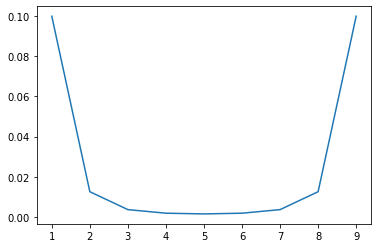

In [4]:
import matplotlib.pyplot as plt 
from scipy.special import binom 

def shap_kernel(z,p):
    #print(binom(p,z))
    #return binom(p,z)
    return (p-1)/(binom(p,z)*(z*(p-z)))
    #return (p-1)/(z*(p-z))
    
n_clients = 10
xx = list(range(1,n_clients))
scaling_factor = shap_kernel(1,n_clients)
print(scaling_factor)
print([shap_kernel(z,n_clients) for z in xx])
plt.plot(xx, [shap_kernel(z,n_clients) for z in xx])

In [5]:
class Net(nn.Module):
    def __init__(self,dataset,out=10):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 100)
        if dataset == 'FEMNIST':
            self.fc2 = nn.Linear(100, 62)
        if dataset == 'MNIST_niid':
            self.fc2 = nn.Linear(100,out)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=-1)

In [6]:
from torch.utils.data import DataLoader
import copy
network = Net('MNIST_niid')
client_models = {}
optimizers = {}
dataloaders = {}
dataloaders_test = {}
for i in range(total_clients):
    client_models[str(i)] = copy.deepcopy(network).double().cuda()
    optimizers[str(i)] = torch.optim.SGD(client_models[str(i)].parameters(),lr=0.01,momentum=0.5)
    dataset_train= MNIST_NIID_dataset(train_data[0],train_data[1],train_partition,i)
    dataloaders[str(i)] = DataLoader(dataset_train,batch_size=16,shuffle=True)
    dataset_test= MNIST_NIID_dataset(test_data[0],test_data[1],test_partition,i)
    dataloaders_test[str(i)] = DataLoader(dataset_test,batch_size=16,shuffle=True)

In [7]:
import random
# Select 5 clients 
selected_clients = [1,2,5,6] #[4,8,9]
# create a (random) graph between them
graph = []
for index,sample in enumerate(selected_clients):
    other_clients = copy.deepcopy(selected_clients)
    other_clients.remove(sample)
    l = [i for i in other_clients]
    graph.append(random.sample(l,k=2))
    
print(graph)

[[6, 2], [5, 1], [6, 1], [2, 5]]


In [8]:
class P2P_AFPL():
    def __init__(self,total_clients,train_data,train_partition,test_data,test_partition): 
        self.network = Net('MNIST_niid')
        self.total_clients = total_clients 
        self.client_models = {}
        self.optimizers = {}
        self.dataloaders = {}
        self.len = {}
        self.len_test = {}
        self.dataloaders_test = {}
        for i in range(total_clients):
            self.client_models[str(i)] = copy.deepcopy(network).double().cuda()
            self.optimizers[str(i)] = torch.optim.SGD(self.client_models[str(i)].parameters(),lr=0.01,momentum=0.5)
            dataset_train= MNIST_NIID_dataset(train_data[0],train_data[1],train_partition,i)
            self.len[str(i)]= len(dataset_train)
            self.dataloaders[str(i)] = DataLoader(dataset_train,batch_size=16,shuffle=True)
            dataset_test= MNIST_NIID_dataset(test_data[0],test_data[1],test_partition,i)
            self.len_test[str(i)] = len(dataset_test)
            self.dataloaders_test[str(i)] = DataLoader(dataset_test,batch_size=16,shuffle=False)
            
    def create_graph(self,selected_clients):
        graph = []
        for index,sample in enumerate(selected_clients):
            other_clients = copy.deepcopy(selected_clients)
            other_clients.remove(sample)
            l = [i for i in other_clients]
            graph.append(random.sample(l,k=2))

        return graph 
    
    def select_clients(self, n_clients=1,total_clients=1, seed=1):
        random.seed(seed)
        l = [i for i in range(total_clients)]
        self.selected_clients = random.sample(l,k=n_clients)
        return self.selected_clients 

    def update_local_models(self,selected_clients):
        self.dw = {}
        for idx,i in enumerate(selected_clients):
            #print("local model i",i)
            dataloader = self.dataloaders[str(i)]
            self.client_models[str(i)].train()
            
            for batch_idx, (data, target) in enumerate(dataloader):
                data = data.double().cuda()
                target=target.long().cuda()

                self.optimizers[str(i)].zero_grad()
                output = self.client_models[str(i)](data)
                loss = F.nll_loss(output,target)
                loss.backward()
                self.optimizers[str(i)].step()
            
            self.client_models[str(i)].eval()
            dataloader_test = self.dataloaders_test[str(i)]
            loss_test = 0 
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(dataloader_test):
                    data = data.double().cuda()
                    target=target.long().cuda()

                    output = self.client_models[str(i)](data)
                    loss_test += F.nll_loss(output,target)
            #print("loss test",loss_test)
            
            loss_test2 = 0 
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(dataloader):
                    data = data.double().cuda()
                    target=target.long().cuda()

                    output = self.client_models[str(i)](data)
                    loss_test2 += F.nll_loss(output,target)
            #print("loss train",loss_test2)
            
        return loss_test/self.len_test[str(i)],loss_test2 /self.len[str(i)]
    
    

            
    def combine_models(self,i,client_numbers):
        zero_copy = copy.deepcopy(self.client_models[str(i)]) # This is used to collect the model in
        j =0
        client_numbers_plus_client = client_numbers + [i] # This is more efficient
        alphas = zero_copy.alphas.detach()
        alphas[i] = 1 - torch.sum(
            torch.tensor([iii for idx, iii in enumerate(alphas) if idx != i and idx in client_numbers]))
        # It's not possible to set the value of self.alphas[i], so instead we determine it manually here

        for ii in client_numbers_plus_client:

            for (name, param),(name2,param2) in zip(zero_copy.named_parameters(),self.client_models[str(ii)].named_parameters()): #self.client_models[str(ii)].named_parameters()):

                if name != 'alphas':
                    if j == 0:
                        param.data = torch.zeros(param.shape).cuda()

                    param.data += alphas[ii]*param2.data # we add all participating client's models to the one here.

            j += 1

        self.client_models[str(i)] = zero_copy.double()
        
    def calc_accuracy(self):
        
        for i in self.selected_clients: 
            dataloader = self.dataloaders_test[str(i)]
            intermediate_accuracy = 0 

            for batch_idx, (data, target) in enumerate(dataloader):
                data = data.double().cuda()
                target = target.long().cuda()
                output = self.client_models[str(i)](data)
                output_array = output.detach().cpu().numpy()
                output_class = np.argmax(output_array,axis=-1)
                target_array = target.detach().cpu().numpy()
                intermediate_accuracy += np.sum(output_class == target_array)

            accuracy = intermediate_accuracy/p2p.len_test[str(i)]*100
            print(i)
            print(accuracy)
            
    def federated_averaging(self):
        self.shared_model = copy.deepcopy(network).double().cuda()
        n_clients = len(self.selected_clients)
        weight = [self.len[str(x)] for x in self.selected_clients]
        weight = weight / np.sum(weight)
        #print("weights ",weight)
        for idx,i in enumerate(self.selected_clients): 
            for (name, param),(name2,param2) in zip(self.shared_model.named_parameters()
                                                      ,self.client_models[str(i)].named_parameters()):
                if idx == 0: 
                    param.data = torch.zeros(param.shape).cuda().double()
                param.data += weight[idx]*param2.data 

        self.shared_model = self.shared_model.double()
        
    def init_models(self):
        for i in self.selected_clients: 
            for (name,param),(name2,param2) in zip(self.shared_model.named_parameters(),
                                                  self.client_models[str(i)].named_parameters()):
                param2.data = copy.deepcopy(param.data)
    
    def compare_favg(self):
        self.shared_model.eval()
        loss_before = []
        loss_after = []
        for ii in self.selected_clients:
            dataloader = self.dataloaders_test[str(ii)]
            loss_test = 0 
            loss_global = 0 
            #print("loss")
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(dataloader):
                    data = data.double().cuda()
                    target=target.long().cuda()
#
                    output = self.client_models[str(ii)](data)
                    outputg = self.shared_model(data)
                    loss_test += F.nll_loss(output,target)
                    loss_global += F.nll_loss(outputg,target)
                     
            loss_before.append(loss_test.detach().cpu().numpy())
            loss_after.append(loss_global.detach().cpu().numpy())
        print("loss before: ",np.sum(loss_before))
        print("loss after: ",np.sum(loss_after))
    
    def loop(self,epochs,graph,mode='disjoint'):
        
        loss_tests = []
        loss_trains = []
        
        for i in range(epochs): 
            self.selected_clients = [0,1,2,3,4,5,6,7,8,9,10,11]
            list1 = []
            self.alphas = torch.ones(self.total_clients,self.total_clients)*(1/3)
            loss_test, loss_train = self.update_local_models(self.selected_clients)
            loss_tests.append(loss_test.detach().cpu().numpy())
            loss_trains.append(loss_train.detach().cpu().numpy())
            
            
            if i < epochs -1 :
                self.federated_averaging()
                self.compare_favg()
                self.init_models()
            else: 
                print("stopped fedavg")
            
        plt.plot(loss_tests,'r-')
        plt.plot(loss_trains,'k-')
        self.calc_accuracy()
        
          #  plt.imshow(data[0,0,:,:].detach().cpu().numpy())

loss before:  24.998579357957425
loss after:  75.32384935177036
loss before:  19.876379886019233
loss after:  29.264698588891616
loss before:  15.087544365717628
loss after:  22.458552123427772
loss before:  12.711201570209226
loss after:  19.190034628952134
loss before:  11.920869340299491
loss after:  16.289616607775756
loss before:  9.82454394865054
loss after:  14.610959381554618
loss before:  9.448641433213089
loss after:  13.131859414369188
loss before:  8.49832883328322
loss after:  12.431413155576465
loss before:  8.789885813814793
loss after:  11.240967075947765
stopped fedavg
0
99.4186046511628
1
99.12790697674419
2
98.12332439678283
3
99.45504087193461
4
98.83720930232558
5
99.12790697674419
6
98.78419452887537
7
99.72752043596729
8
99.08814589665653
9
99.69604863221885
10
100.0
11
98.04469273743017


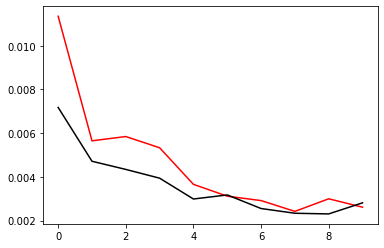

In [9]:
import collections
p2p = P2P_AFPL(total_clients,train_data,train_partition,test_data,test_partition)
alphas = p2p.loop(10,graph,p2p)


In [32]:
from sklearn.linear_model import LinearRegression
class calculate_SHAP(SHAP_kernel):
    def __init__(self,selected_clients,dataset,samples,p2p):
        super().__init__(len(selected_clients),samples,verbose=False)
        self.n_clients = len(selected_clients)
        self.samples = samples
        self.dataset = dataset
        self.selected_clients = selected_clients
        self.p2p = p2p 
        self.define_shap()
        
    def define_shap(self):
        # define Shap kernel
        self.forward_shap()
        coalition_object = create_coalitions(self.adjusted,self.weights,self.n_clients)
        self.masks, self.weights = coalition_object.forward()
        
        self.masks = np.asarray(self.masks,dtype='bool')
        
    def combine_models(self,p2p,coalitions):
        shared_model = copy.deepcopy(p2p.network).double().cuda()
        n_clients = len(self.selected_clients)
        weight = [p2p.len[str(x)] for x in coalitions]
        weight = weight / np.sum(weight) #weight is wrong 
        #print("weights ",weight)
        for idx,i in enumerate(coalitions): 
            for (name, param),(name2,param2) in zip(shared_model.named_parameters()
                                                      ,p2p.client_models[str(i)].named_parameters()):
                if idx == 0: 
                    param.data = torch.zeros(param.shape).cuda().double()
                param.data += weight[idx]*param2.data 
        shared_model = shared_model.double()
        return shared_model
    
    def calc_fnull(self,client): 
        # we calculate the prediction of the model of client ...  
        shared_model = self.combine_models(self.p2p,np.array([client]))
        shared_model.eval().cuda()
        fnull = np.zeros((p2p.len_test[str(client)],1))
        for batch_idx, (data, target) in enumerate(p2p.dataloaders_test[str(client)]):
            data = data.double().cuda()
            target = target.long().cuda()
            fnull[batch_idx*16:batch_idx*16+len(target)] = np.reshape(F.nll_loss(shared_model(data),target,reduction='none').detach().cpu().numpy(),(len(target),1))
        return fnull
        
    def calc_fx(self,client):
        selected_clients = np.concatenate((self.selected_clients,np.array([client])))
        shared_model = self.combine_models(self.p2p,selected_clients)
        shared_model.eval().cuda()
        #fx = np.zeros((len(p2p.dataloaders_test[str(10)]),1))
        fx = np.zeros((p2p.len_test[str(client)],1))
        for batch_idx, (data, target) in enumerate(p2p.dataloaders_test[str(client)]):
            data = data.double().cuda()
            target = target.long().cuda()
            fx[batch_idx*16:batch_idx*16 + len(target)] = np.reshape(F.nll_loss(shared_model(data),target,reduction='none').detach().cpu().numpy(),(len(target),1))
        #print(fx)
        return fx
    
    def first_check(self,mean_fnull,client):
        ey = np.zeros((len(self.masks),p2p.len_test[str(client)])) # fix indices 
        for i,coalition in enumerate(self.masks[:len(self.selected_clients),:]): 
            selected_clients_coalition = np.concatenate((self.selected_clients[coalition],np.array([client])))
            shared_model = self.combine_models(self.p2p,selected_clients_coalition)
            shared_model.eval().cuda()
            for batch_idx, (data, target) in enumerate(p2p.dataloaders_test[str(client)]):
                data = data.double().cuda()
                target = target.long().cuda()

                ey[i,batch_idx*16:batch_idx*16+len(target)] = F.nll_loss(shared_model(data),target,reduction='none').detach().cpu().numpy()
            
            # check if ey is better or worse than fnull: 
            if i == len(self.selected_clients)-1: 
                print('scores after adding model',np.mean(ey[:i,:],axis=1))
                #print(np.where(np.mean(ey[:i,:],axis=1)<=mean_fnull))
                selected_clients_index = np.where(np.mean(ey[:i,:],axis=1)<=mean_fnull+0*mean_fnull )
                print("selected clients: ",self.selected_clients[selected_clients_index])
                selected_clients = self.selected_clients[selected_clients_index]
        if len(selected_clients) != len(self.selected_clients) and len(selected_clients) > 1:
            self.__init__(selected_clients,self.dataset,self.samples,self.p2p)
            ey2 = np.zeros((len(self.masks),p2p.len_test[str(client)]))
            ey2[:len(self.selected_clients),:] = ey[selected_clients_index,:]
            ey = ey2 
        return ey, selected_clients 
    
    def solve(self,fnull,ey):
        # Transform to k-dimensional least squares problem 
        k = len(fnull)
        coalitions = len(self.masks)
        M = len(self.selected_clients)
        eyAdjb = []
        for kk in range(k): 
            #eyAdjb[kk*c:(kk+1)*199]
            eyAdjb.append(list(ey[:,kk] -fnull[kk]))

        eyAdjb = sum(eyAdjb,[])
        etmp = self.masks
        X = np.tile(etmp, (k,1))
        y = np.array(eyAdjb)
        w = np.tile(self.weights, k)
        reg = LinearRegression(fit_intercept=False).fit(X,y,sample_weight=w)
        return reg.coef_

    
    def forward2(self,client,evaluation="loss"):
        # calculate fnull, prediction without knowledge (empty initialized model)
        fnull = self.calc_fnull(client)
        mean_fnull = np.mean(fnull)
        print("score without collaboration: ",mean_fnull)

        # first check if ey is better or worse than fnull: 
        ey, selected_clients = self.first_check(mean_fnull,client)
        print(np.mean(ey[:10,:],axis=1))
        #selected_clients = self.selected_clients 
        print(selected_clients)
        if len(selected_clients) > 1: 

            # calculate ey, output for all coalitions 
            for i,coalition in enumerate(self.masks[len(self.selected_clients):,:]): 
                selected_clients_coalition = np.concatenate((self.selected_clients[coalition],np.array([client])))
                shared_model = self.combine_models(self.p2p,selected_clients_coalition)
                shared_model.eval().cuda()
                for batch_idx, (data, target) in enumerate(p2p.dataloaders_test[str(client)]):
                    data = data.double().cuda()
                    target = target.long().cuda()
                    ey[i+len(self.selected_clients),batch_idx*16:batch_idx*16+len(target)] = F.nll_loss(shared_model(data),target,reduction='none').detach().cpu().numpy()

            # calculate fx 
            #fx = self.calc_fx(client)

            #masks = np.asarray(self.masks,dtype = 'int')
            #,masks,len(self.selected_clients),fx,0,self.weights)
           # mean = np.mean(ey,axis=1)
           # print(np.mean(mean))
           # print(fnullf)
            #print(mean-mean_fnull<0)
          #  self.weights = self.weights[mean-mean_fnull<0]
           # self.masks = self.masks[mean-mean_fnull<0,:]
           # if sum(mean-mean_fnull<0) > 1: 
                #phi = self.solve(fnull,ey[mean-mean_fnull<0,:]) 
            phi = self.solve(fnull,ey) 
            selected_clients_index = np.argmin(phi) #np.where(phi<0)
            #selected_clients_index = self.masks[np.argmin(mean-fnullf),:]
            #phi = np.zeros(self.selected_clients)

            #self.ey2 = ey[mean-mean_fnull<0,:] 
            self.ey = ey 
            selected_clients = selected_clients[selected_clients_index]

            selected_clients = np.concatenate((np.array([selected_clients]),np.array([client])))
            #else: 
              #  phi = np.zeros(self.selected_clients)
             #   print('no one selected')
               # selected_clients = np.array([client])
            
            
            #print(phi)
           # print(selected_clients)
            # check score: 
            shared_model = self.combine_models(self.p2p,selected_clients)
            shared_model.eval()
            f_after = np.zeros(p2p.len_test[str(client)])
            for batch_idx, (data, target) in enumerate(p2p.dataloaders_test[str(client)]):
                    data = data.double().cuda()
                    target = target.long().cuda()
                    f_after[batch_idx*16:batch_idx*16+len(target)] = F.nll_loss(shared_model(data),target,reduction='none').detach().cpu().numpy()
            print("score after: ",np.mean(f_after))
            self.ey = ey 
            self.fnull = fnull 
            return phi, selected_clients,mean_fnull,np.mean(f_after)
        else: 
            print("no clients selected")
            shared_model = self.combine_models(self.p2p, np.concatenate((selected_clients,np.array([client]))))
            shared_model.eval()
            f_after = np.zeros(p2p.len_test[str(client)])
            for batch_idx, (data, target) in enumerate(p2p.dataloaders_test[str(client)]):
                    data = data.double().cuda()
                    target = target.long().cuda()
                    f_after[batch_idx*16:batch_idx*16+len(target)] = F.nll_loss(shared_model(data),target,reduction='none').detach().cpu().numpy()
            print("score after: ",np.mean(f_after))
            return 0, selected_clients,mean_fnull,np.mean(f_after)
        #print(phi)
        #return ey, fnull, fx , masks, self.weight


In [33]:
from time import time 
selected_clients = [0,1,2,3,4,5,6,7,8,9,10,11]

print(selected_clients)
fnull = np.zeros(len([0,1,2,3,4,5,6,7,8,9,10,11]))
fafter = np.zeros(len([0,1,2,3,4,5,6,7,8,9,10,11]))

for i in selected_clients: 
    before = time()
    selected_clients = [0,1,2,3,4,5,6,7,8,9,10,11]
    client = i
    print(client)
    selected_clients.remove(client)
    calc_shap2 = calculate_SHAP(np.array(selected_clients),dataset_train,200,p2p)
    phi,selected_clients2,fnullf,fafterf = calc_shap2.forward2(client)
    fnull[i] =fnullf 
    fafter[i] = fafterf
    after = time() - before 
    print('duration = ',after,'seconds')
    print(phi)
    print(selected_clients2)
    #if len(selected_clients2) > 1: 
    #    plt.plot(selected_clients2,phi)
    #    plt.plot(selected_clients2[np.where(phi<0)[0]],phi[phi<0],'or')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
0
score without collaboration:  0.02143847743742103
scores after adding model [0.01834818 0.02382473 0.0966521  0.02273196 0.01663127 0.0217829
 0.05941889 0.02785349 0.02436077 0.0230579 ]
selected clients:  [1 5]
[0.01834818 0.01663127]
[1 5]
score after:  0.01663127215846291
duration =  0.6415901184082031 seconds
[-0.00309029 -0.00480721]
[5 0]
1
score without collaboration:  0.02614427427455551
scores after adding model [0.02459461 0.03276486 0.13204292 0.02539952 0.02889178 0.03922299
 0.09177515 0.04155036 0.0505932  0.04691883]
selected clients:  [0 4]
[0.02459461 0.02539952]
[0 4]
score after:  0.02459461471026251
duration =  0.5398187637329102 seconds
[-0.00154966 -0.00074475]
[0 1]
2
score without collaboration:  0.05376161274973698
scores after adding model [0.09605913 0.0861034  0.14058024 0.08831694 0.09461838 0.06378365
 0.10354379 0.06907531 0.06599654 0.06439885]
selected clients:  []
[0.09605913 0.0861034  0.14058024 0.08831694 0.

0.32892193430758315
0.28449779311639123


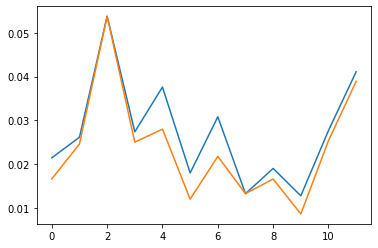

In [34]:
plt.plot(fnull)
plt.plot(fafter)
print(np.sum(fnull))
print(np.sum(fafter))

0.32892193430758315
0.2860052317829586


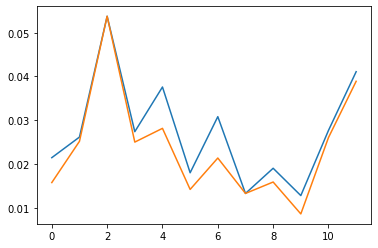

In [25]:
plt.plot(fnull)
plt.plot(fafter)
print(np.sum(fnull))
print(np.sum(fafter))

0.3211206872381347
0.2656580438430252


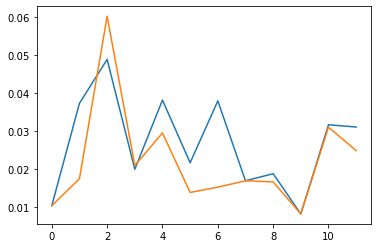

In [490]:
plt.plot(fnull)
plt.plot(fafter)
print(np.sum(fnull))
print(np.sum(fafter))

0.3211206872381347
0.4001198772337168


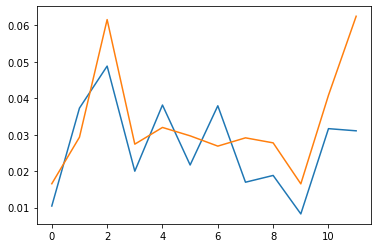

In [412]:
plt.plot(fnull)
plt.plot(fafter)
print(np.sum(fnull))
print(np.sum(fafter))

0.3211206872381347
0.25681575631615877


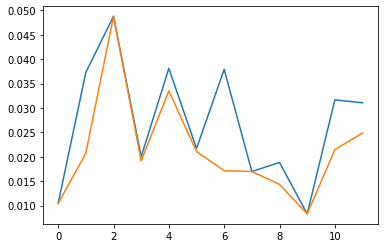

In [405]:
plt.plot(fnull)
plt.plot(fafter)
print(np.sum(fnull))
print(np.sum(fafter))

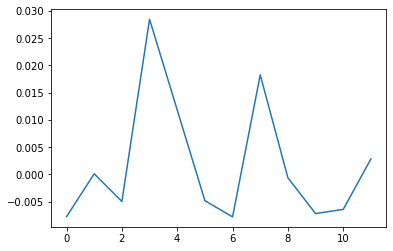

In [452]:
plt.plot(selected_clients2,phi)
plt.plot(selected_clients2[np.where(phi<0-fnullf)[0]],phi[phi<0-fnullf],'or')

In [493]:
print(np.shape(calc_shap2.ey))
mean = np.mean(calc_shap2.ey,axis=1)
print(np.mean(mean))
print(fnullf)
print(mean-fnullf<0)
print(np.argmin(mean-fnullf))


(200, 358)
0.054790597576527746
0.031065252215273204
[False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False Fals

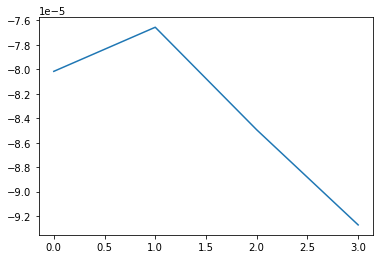

In [492]:
plt.plot(phi_raw2)

In [166]:
print(np.sum(fnull))
print(len(fnull))
print(np.shape(ey))
print(np.sum(ey[:10,:],axis=1))

2.0041746437988315
385
(199, 385)
[ 2.85067561 34.23242731 28.46502853 57.77997824 42.66504333 31.44413806
 31.63388345 26.40855657 23.37118121 41.93235146]


In [167]:
shared_model = calc_shap2.combine_models(p2p,[0])
shared_model.eval().cuda()
ey2 = np.zeros(384)
for batch_idx, (data, target) in enumerate(p2p.dataloaders_test[str(10)]):
    data = data.double().cuda()
    target = target.long().cuda()

    ey2[batch_idx*16:batch_idx*16+len(target)] = F.nll_loss(shared_model(data),target,reduction='none').detach().cpu().numpy()
print(np.sum(ey2))

5.814358681478112


#### old code 

(199, 9)
(199,)
(199,)
[-0.03823057  0.01365829  0.01032824 -0.03841841  0.01044364  0.00292917
  0.01275646  0.00647827  0.01105955  0.00881592]
[ 2.84122588e-05 -9.50978280e-05 -1.47165710e-05  1.97944806e-06
 -2.43449045e-05  1.31015823e-05 -7.20295803e-05  8.06776010e-06
  1.11937203e-05 -3.60065538e-05]
[-0.03588396  0.00968889  0.0093388  -0.0368585   0.01381635  0.00304845
  0.01084023  0.00907289  0.01001535  0.00674205]
[-0.03588396  0.00968889  0.0093388  -0.0368585   0.01381635  0.00304845
  0.01084023  0.00907289  0.01001535]


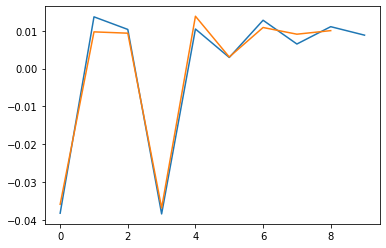

In [88]:
from sklearn.linear_model import LinearRegression
X = etmp 
y = eyAdj2
w = calc_shap2.weights
print(np.shape(X))
print(np.shape(y))
print(np.shape(w))

reg  = LinearRegression().fit(X,y,sample_weight=w)
phi_raw = reg.coef_ 
phi = np.zeros(M)
phi[nonzero_inds[:-1]] = phi_raw
phi[nonzero_inds[-1]] = ((fx_array[dim]) - (fnull_array[dim])) - sum(phi_raw)
#print(reg.coef_)
print(phi)
print(phis_single2[dim,:])
phi3 = calc_shap2.solve(np.reshape(ey[dim],(199,1)),np.reshape(fnull_array[dim],(1,1))
                        ,maskMatrix,10,np.reshape(fx_array[dim],(1,1)),dim,w)
print(phi3)
#plt.plot(X[:,0],y,".")
tmp = np.transpose(np.transpose(etmp) * np.transpose(w))
#print("tmp ",np.shape(tmp))
etmp_dot = np.dot(np.transpose(tmp), etmp)

tmp2 = np.linalg.inv(etmp_dot)
phi4 = np.dot(tmp2, np.dot(np.transpose(tmp), eyAdj2))
print(phi4)
plt.plot(phi)
plt.plot(phi4)
    

In [119]:
# instead of normalizing, just count how often participating with this client would bring the loss down. 
phi_count = np.zeros((348,10))
#epsilon = -0.0001
phi_benefit = np.zeros((348,10))
phi_loss = np.zeros((348,10))

for i in range(348): 
    negative_indices = phi_gt_single[i,:] < 0 + epsilon
    positive_indices = phi_gt_single[i,:] >= 0 + epsilon  
    
    phi_count[i,negative_indices] = 1 
    phi_benefit[i,negative_indices] = -fnull[i]#phi_gt_single[i,negative_indices]
    phi_loss[i,positive_indices] = fnull[i]#phi_gt_single[i,positive_indices]
print(np.sum(phi_count,axis=0))

[ 60. 134.  99. 110.  57.   7.  65.  67.  34.  31.]


In [146]:
initial_model = calc_shap2.combine_models(p2p,np.array([10]))

shared_model = calc_shap2.combine_models(p2p,np.array([0,1,2,3,4,5,6,7,8,9,10]))
shared_model2 = calc_shap.combine_models(p2p,np.array([0,1,2,3,7,10]))
shared_model3 = calc_shap.combine_models(p2p,np.array([1,2,3,10]))
#shared_model3 = calc_shap2.combine_models(p2p,np.array([0,1,2,3,4,6,7,8,9,10]))
shared_model.eval()
shared_model2.eval()
shared_model3.eval()

f_null = 0 
f_opt = 0 
f_opt2 = 0 
f_opt3 = 0 

k = 0 
for batch_idx, (data, target) in enumerate(p2p.dataloaders_test[str(10)]):
    for ii in range(len(target)):
        instance = (data[ii],target[ii])

        f_null += F.nll_loss(initial_model(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
        f_opt += F.nll_loss(shared_model(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
        f_opt2 += F.nll_loss(shared_model2(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
        f_opt3 += F.nll_loss(shared_model3(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()

        k += 1 
print(f_null)
print(f_opt)
print(f_opt2)
print(f_opt3)

5.739251866123742
1.7992195154017812
1.4799153831717595
1.4789712477724615
